In [1]:
import tensorflow as tf
import numpy as np
import time
import os

In [2]:
from spatial_transformer import transformer

In [3]:
data = np.load('./data/mnist_cluttered_60x60_6distortions.npz')
img_train = data['x_train'].reshape(50000, 60, 60)
label_train = np.argmax(data['y_train'], axis=-1)
img_test = data['x_test'].reshape(10000, 60, 60)
label_test = np.argmax(data['y_test'], axis=-1)

In [4]:
print(img_train.shape, label_train.shape, img_test.shape, label_test.shape)

(50000, 60, 60) (50000,) (10000, 60, 60) (10000,)


In [5]:
def Conv_block(inputs, filters, scope_num):
    with tf.variable_scope('{}/conv_layer'.format(model, scope_num)):
        conv = tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=[3, 3], 
                                padding='SAME', activation=tf.nn.relu, 
                                name='conv{}'.format(scope_num))
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], 
                                       padding='SAME', strides=2, 
                                       name='pool{}'.format(scope_num))
    return pool

In [6]:
def get_accuracy(sess, logits, img, label, batch_size):    
    if len(img) < batch_size:
        logit = sess.run(logits, feed_dict={X: img, keep_prob: 1.0})
    else:
        total_batch = int(len(img) / batch_size) + 1
        num_label = int(logits.shape[-1])
        logit = np.array([], dtype=np.int64).reshape(0, num_label)
        idxs = range(len(img))
        for i in range(total_batch):
            if i < (total_batch - 1):
                idxs_i = idxs[i * batch_size : (i + 1) * batch_size]
            else:
                idxs_i = idxs[i * batch_size : len(img)]
            feed_dict = {X: img[idxs_i], keep_prob: 1.0}
            logit = np.concatenate((logit, sess.run(logits, feed_dict=feed_dict)), axis=0)

    correct_pred = np.equal(np.argmax(logit, 1), label).astype(np.float32)
    accuracy = np.mean(correct_pred)
    
    return accuracy, logit, correct_pred

In [7]:
# hyper prameter
model = 'STN-distorted'
batch_size = 128
epochs = 100
CHECK_POINT_DIR = './save_model_{}'.format(model)

In [8]:
img_row, img_col = img_train.shape[1], img_train.shape[2]
img_depth = 1

img_train = img_train.reshape(img_train.shape[0], img_row, img_col, img_depth)
img_test = img_test.reshape(img_test.shape[0], img_row, img_col, img_depth)
img_train = img_train.astype(np.float32)
img_test = img_test.astype(np.float32)

In [9]:
X = tf.placeholder(tf.float32, [None, img_row, img_col, img_depth])
Y = tf.placeholder(tf.int64, [None])
keep_prob = tf.placeholder(tf.float32)

In [10]:
# localization network
x_flat_num = img_row * img_col * img_depth
X_flat = tf.reshape(X, [-1, x_flat_num])

initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32')
initial = initial.flatten()

with tf.variable_scope('{}/localization'.format(model)):
    dense_loc1 = tf.layers.dense(inputs=X_flat, units=20, 
                                 kernel_initializer=tf.zeros_initializer(),
                                 bias_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
                                 name='dense_loc1')
    drop_loc1 = tf.nn.dropout(x=dense_loc1, keep_prob=keep_prob, name='drop_loc1')    
    act_loc1 = tf.nn.tanh(drop_loc1, name='act_loc1')
    dense_loc2 = tf.layers.dense(inputs=act_loc1, units=6, 
                                 kernel_initializer=tf.zeros_initializer(),
                                 bias_initializer=tf.constant_initializer(initial) ,name='dense_loc2')
    drop_loc2 = tf.nn.dropout(x=dense_loc2, keep_prob=keep_prob, name='drop_loc2')
    act_loc2 = tf.nn.tanh(drop_loc2, name='act_loc2')

In [11]:
out_size = (img_row, img_col)
loc_trans = transformer(X, act_loc2, out_size)

In [12]:
loc_trans = tf.squeeze(loc_trans, axis=-1)
loc_trans = tf.expand_dims(loc_trans, axis=-1)

In [13]:
loc_trans

<tf.Tensor 'ExpandDims:0' shape=(?, 60, 60, 1) dtype=float32>

In [14]:
# build network
# convolution layers

block1 = Conv_block(inputs=loc_trans, filters=32, scope_num=1)
block2 = Conv_block(inputs=block1, filters=32, scope_num=2)
conv = Conv_block(inputs=block2, filters=32, scope_num=3)

In [15]:
# fully connected layers

flat_num = int(conv.shape[1] * conv.shape[2] * conv.shape[3])
flat = tf.reshape(conv, [-1, flat_num])

with tf.variable_scope('{}/fc_layer'.format(model)):
    dense1 = tf.layers.dense(inputs=flat, units=512, 
                            activation=tf.nn.relu, name='dense1')
    drop1 = tf.nn.dropout(x=dense1, keep_prob=keep_prob)
    dense2 = tf.layers.dense(inputs=drop1, units=512, 
                            activation=tf.nn.relu, name='dense2')
    drop2 = tf.nn.dropout(x=dense2, keep_prob=keep_prob)
    logits = tf.layers.dense(inputs=drop2, units=10, name='logit')        

In [16]:
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

correct_prediction = tf.equal(tf.argmax(logits, 1), Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
config=tf.ConfigProto(allow_soft_placement=True)
#config.gpu_options.allocator_type='BFC'
config.log_device_placement=False
config.gpu_options.allow_growth=True
#config.gpu_options.per_process_gpu_memory_fraction = 0.40

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [18]:
# Restore and Save

saver = tf.train.Saver()
checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)

if checkpoint and checkpoint.model_checkpoint_path:
    epoch_num = int(checkpoint.model_checkpoint_path.split('-')[-1]) + 1
    max_accuracy, _, _= get_accuracy(sess, logits, img_test, label_test, batch_size)
    try:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    except:
        print("Error on loading old network weights")
else:
    epoch_num = 1
    max_accuracy = 0.0
    print("Could not find old network weights")

INFO:tensorflow:Restoring parameters from ./save_model_STN-distorted\model-24
Successfully loaded: ./save_model_STN-distorted\model-24


In [21]:
# train

print(time.asctime())
print ('Learning Started.')

total_start = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    avg_cost = 0
    total_batch = int(img_train.shape[0] / batch_size) + 1
    
    idxs = np.random.permutation(range(len(img_train)))
    for i in range(total_batch):
        if i < (total_batch - 1):        
            idxs_i = idxs[i * batch_size : (i + 1) * batch_size]
        else:
            idxs_i = idxs[i * batch_size : len(img_train)]
            
        feed_dict = {X: img_train[idxs_i], Y: label_train[idxs_i], keep_prob: 0.8}    
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    print ('=====================================')
    print ('Epoch : {:02d} , Cost : {:.5f}'.format(epoch + epoch_num, avg_cost))
    train_accuracy, _, _ = get_accuracy(sess, logits, img_train, label_train, batch_size)
    print ('Train Accuracy : {:.5f}'.format(train_accuracy))
    test_accuracy, _, _ = get_accuracy(sess, logits, img_test, label_test, batch_size)
    print ('Test Accuracy : {:.5f}'.format(test_accuracy))
    print ('Elapsed time of an epoch: {:.5f}'.format(time.time() - epoch_start))
    if test_accuracy > max_accuracy:
        max_accuracy = test_accuracy
        print ('===========Saving network with the best accuracy===========')
        if not os.path.exists(CHECK_POINT_DIR):
            os.makedirs(CHECK_POINT_DIR)
        saver.save(sess, CHECK_POINT_DIR + "/model", global_step=epoch+epoch_num)

print ('=====================================')

print ('Final Test Accuracy : {:.5f}'.format(max_accuracy))
print ('Total elapsed time: {:.5f}'.format(time.time() - total_start))

Wed Jan 31 23:44:18 2018
Learning Started.
Epoch : 01 , Cost : 1.76497
Train Accuracy : 0.75570
Test Accuracy : 0.74790
Elapsed time of an epoch: 39.72270
===========Saving network with the best accuracy===========
Epoch : 02 , Cost : 1.11563
Train Accuracy : 0.89372
Test Accuracy : 0.88850
Elapsed time of an epoch: 39.03566
===========Saving network with the best accuracy===========
Epoch : 03 , Cost : 0.99810
Train Accuracy : 0.92886
Test Accuracy : 0.92000
Elapsed time of an epoch: 39.02176
===========Saving network with the best accuracy===========
Epoch : 04 , Cost : 0.95583
Train Accuracy : 0.94030
Test Accuracy : 0.93440
Elapsed time of an epoch: 39.19190
===========Saving network with the best accuracy===========
Epoch : 05 , Cost : 0.92990
Train Accuracy : 0.94424
Test Accuracy : 0.93880
Elapsed time of an epoch: 39.35032
===========Saving network with the best accuracy===========
Epoch : 06 , Cost : 0.89848
Train Accuracy : 0.95078
Test Accuracy : 0.94710
Elapsed time of an e

KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt

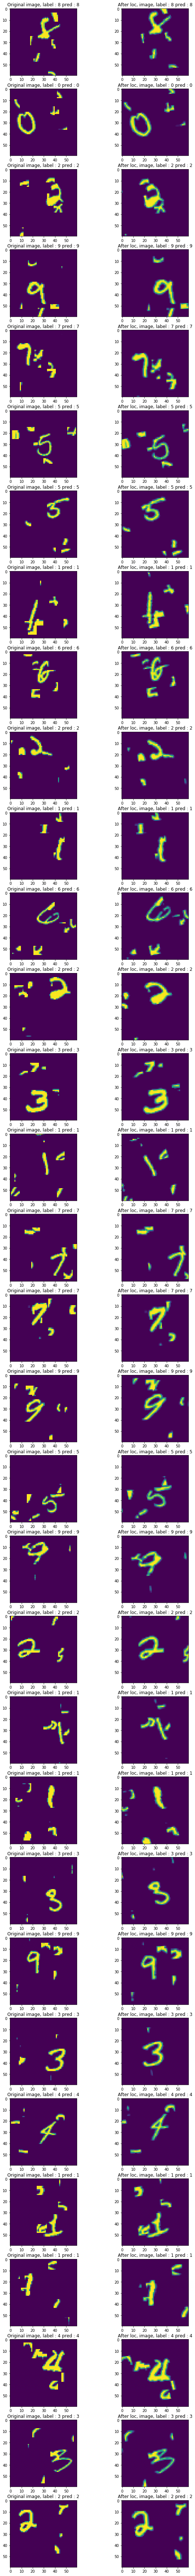

In [20]:
img = img_train[0:32]
label = label_train[0:32]
loc = sess.run(loc_trans, feed_dict={X: img, keep_prob: 1.0 })
_, te_pred, _ = get_accuracy(sess, logits, img, label, batch_size)
te_pred = np.argmax(te_pred, axis=-1)

fig, ax = plt.subplots(nrows=len(img), ncols=2, figsize = (10, 4*len(img)))

for i in range(len(img)):
    ax[i][0].imshow(img[i].reshape(60,60))
    ax[i][0].set_title('Original image, label : {} pred : {}'.format(label[i], 
                                                                     te_pred[i]))
    ax[i][1].imshow(np.squeeze(loc[i], axis=-1))
    ax[i][1].set_title('After loc, image, label : {} pred : {}'.format(label[i], 
                                                                     te_pred[i]))    
plt.show()

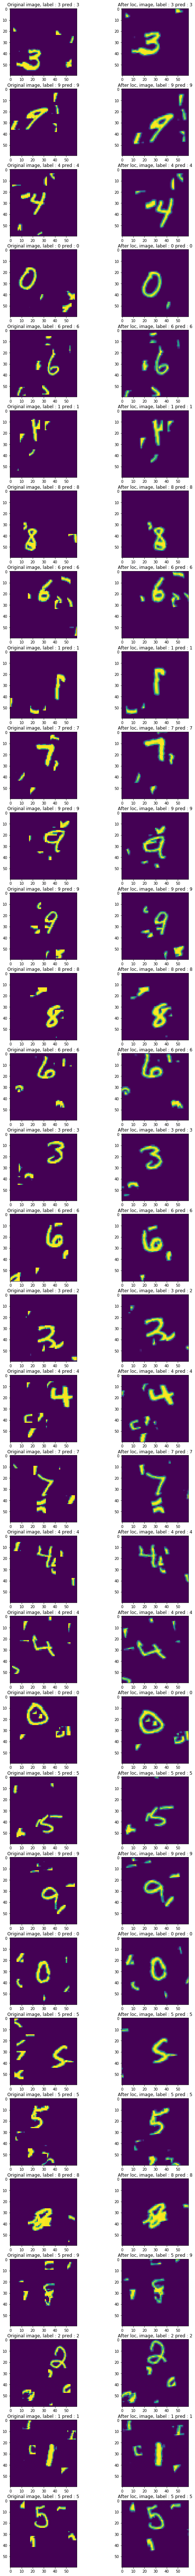

In [21]:
img = img_test[0:32]
label = label_test[0:32]
loc = sess.run(loc_trans, feed_dict={X: img, keep_prob: 1.0 })
_, te_pred, _ = get_accuracy(sess, logits, img, label, batch_size)
te_pred = np.argmax(te_pred, axis=-1)

fig, ax = plt.subplots(nrows=len(img), ncols=2, figsize = (10, 4*len(img)))

for i in range(len(img)):
    ax[i][0].imshow(img[i].reshape(60,60))
    ax[i][0].set_title('Original image, label : {} pred : {}'.format(label[i], 
                                                                     te_pred[i]))
    ax[i][1].imshow(np.squeeze(loc[i], axis=-1))
    ax[i][1].set_title('After loc, image, label : {} pred : {}'.format(label[i], 
                                                                     te_pred[i]))    
plt.show()